In this notebook I implement the logistic regression. The dataset used is available in [kaggle](https://www.kaggle.com/datasets/prathamtripathi/drug-classification) and represents the use of two types of drug, with features of users.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from tabulate import tabulate
import math

In [3]:
connection = sqlite3.connect('data/Drug.db')
cursor = connection.cursor()

In [ ]:
cursor.executescript("""CREATE TABLE IF NOT EXISTS results(method TEXT, scale TEXT, w1 REAL, w2 REAL, b REAL)
""")

In [4]:
df = pd.read_csv('data/drug200.csv')
df_sql = df.to_sql('drug', con=connection, if_exists='append', index=False)

In [5]:
schema = cursor.execute('SELECT sql FROM sqlite_master').fetchall()
print(tabulate(schema))

-----------------------------------------------------------------------
CREATE TABLE "drug" (
"Age" INTEGER,
  "Sex" TEXT,
  "BP" TEXT,
  "Cholesterol" TEXT,
  "Na_to_K" REAL,
  "Drug" TEXT
)
CREATE TABLE results(method TEXT, scale TEXT, w1 REAL, w2 REAL, b REAL)
-----------------------------------------------------------------------


In [4]:
cursor.execute("SELECT *  from drug")
data = np.array(cursor.fetchall())
print(tabulate(data[:10]))

X = data[:,0::4]
X = X.astype(np.float64)
y = data[:,-1]
y[y == 'DrugY'] = 0
y[y == 'drugX'] = 0
y[y == 'drugC'] = 1
y[y == 'drugB'] = 1
y[y == 'drugA'] = 1
y = y.astype(np.float64)

--  -  ------  ------  ------  -----
23  F  HIGH    HIGH    25.355  DrugY
47  M  LOW     HIGH    13.093  drugC
47  M  LOW     HIGH    10.114  drugC
28  F  NORMAL  HIGH     7.798  drugX
61  F  LOW     HIGH    18.043  DrugY
22  F  NORMAL  HIGH     8.607  drugX
49  F  NORMAL  HIGH    16.275  DrugY
41  M  LOW     HIGH    11.037  drugC
60  M  NORMAL  HIGH    15.171  DrugY
43  M  LOW     NORMAL  19.368  DrugY
--  -  ------  ------  ------  -----


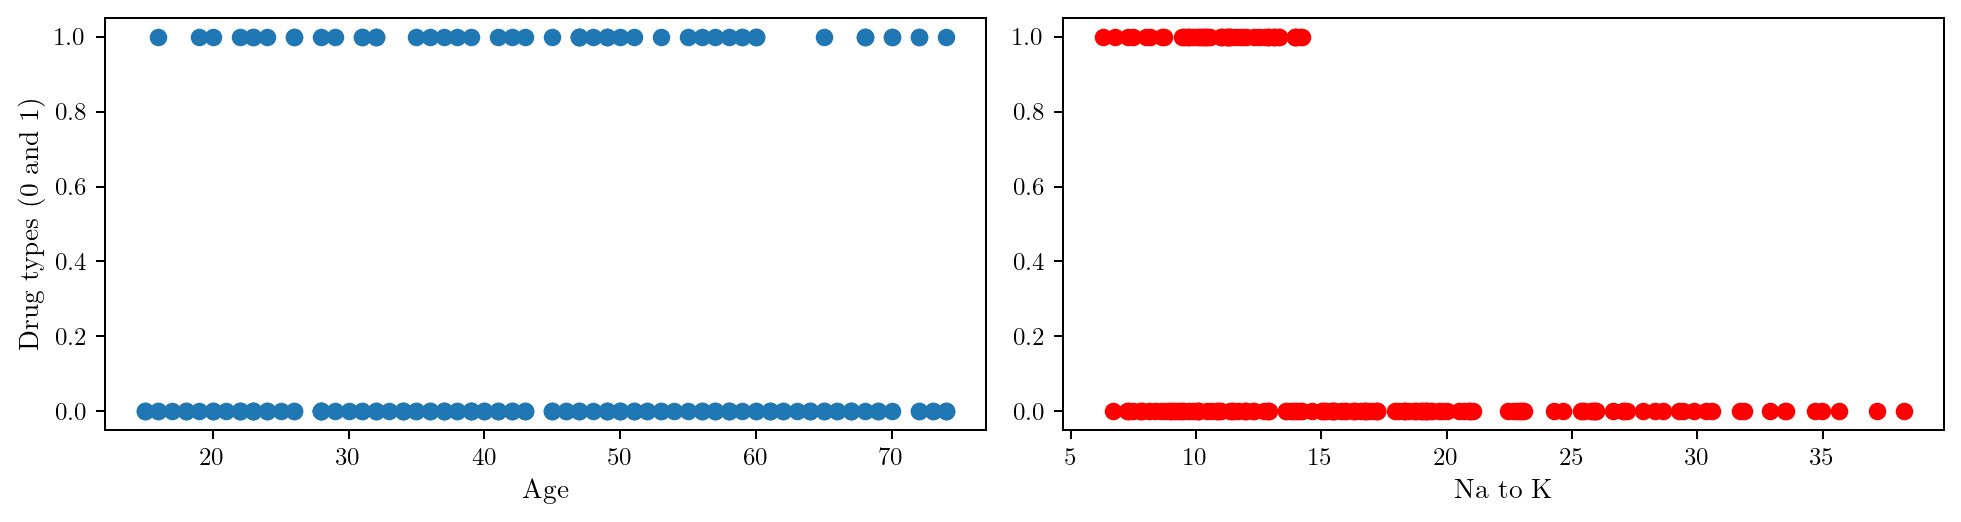

In [398]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,3), dpi=180)
ax1.scatter(X[:,0], y)
ax2.scatter(X[:,1],y,c='r')

pt = 11
ax1.set_xlabel(r'Age',fontsize=pt)
ax2.set_xlabel(r'Na to K',fontsize=pt)
ax1.set_ylabel(r'Drug types (0 and 1)',fontsize=pt)
plt.tight_layout()
plt.show()

$$J(\vec{X},\vec{w},b) = \frac{1}{2m} \sum_{i=0}^{m-1} (f_{\vec{w}b}(\vec{X}^{(i)}) - y^{(i)})^2 = \frac{1}{m} \sum_{i=0}^{m-1} L(f_{\vec{w}b},\vec{X}^{(i)}) $$

$$f_{\vec{w}b} = g(z) = \frac{1}{1+e^{-z}}$$

$$z = \vec{w}  \vec{X} + b$$

$$ L(f_{\vec{w}b},\vec{X}^{(i)}) = y^{(i)} \log{(f_{\vec{w}b}^{(i)})} - (1-y^{(i)})\log{(1-f_{\vec{w}b}^{(i)})} $$

In [4]:
def scale_z_score(x_train):
    mean = np.mean(x_train,axis=0)
    sigma = np.std(x_train,axis=0)
    x_scaled = (x_train - mean)/sigma
    return x_scaled, mean, sigma

Xs, mean, sigma = scale_z_score(X)

In [5]:
def sigmoid(z):
    z = np.clip(z, -700, 700)
    g = 1/(1+np.exp(-z))
    return g

In [6]:
def cost_regularized(X, y, w, b, lambda_):
    m,n = X.shape

    cost = 0
    w_sum = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z)
        f_wb_i = np.clip(f_wb_i, 1e-300,1)
        diff = 1-f_wb_i
        diff = np.clip(diff, 1e-300,1)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(diff)
    total_cost = 1/m*cost

    #regularization to avoid overfitting
    w_sum = np.sum(w**2)
    reg = lambda_/(2*m) * w_sum
    total_cost += reg
    
    return total_cost

In [7]:
def gradient_regularized(X, y, w, b, lambda_):
    m,n = X.shape
    
    dj_dw = np.zeros(n)
    dj_db = 0

    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        for j in range(n):
            dj_dw_i = (f_wb_i - y[i]) * X[i,j]
            dj_dw[j] += dj_dw_i
        dj_db_i = f_wb_i - y[i]
        dj_db += dj_db_i
    
    dj_dw = 1/m*dj_dw
    dj_db = 1/m*dj_db

    for j in range(n):
        dj_dw[j] += lambda_/m * w[j]

    return dj_dw, dj_db

In [8]:
def gradient_descent(X, y, w, b, alpha, lambda_, n_iter):
    m,n = X.shape

    J_hist = []
    w_hist = []
    b_hist = []

    for k in range(n_iter):
        dj_dw, dj_db = gradient_regularized(X, y, w, b, lambda_)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_hist.append(cost_regularized(X, y, w, b, lambda_))
        w_hist.append(w)
        b_hist.append(b)

        if k % math.ceil(n_iter/10) == 0:
            print(f'Iteration {k:4d}: Cost {J_hist[-1]}')
    return w, b, J_hist, w_hist, b_hist

In [12]:
m,n = X.shape
w_init = np.zeros(n)
b_init = 2.5
alpha = 1e-3
lambda_ = 0.5

w, b, J_hist, w_hist, b_hist = gradient_descent(X, y, w_init, b_init, alpha, lambda_, 10000)

Iteration    0: Cost 1.0753241956171051
Iteration 1000: Cost 0.44987320837272815
Iteration 2000: Cost 0.44986070466796413
Iteration 3000: Cost 0.44985996187094085
Iteration 4000: Cost 0.4498592339720712
Iteration 5000: Cost 0.4498585169717381
Iteration 6000: Cost 0.4498578107041046
Iteration 7000: Cost 0.4498571150071191
Iteration 8000: Cost 0.44985642972121104
Iteration 9000: Cost 0.44985575468924865


In [ ]:
cursor.execute("INSERT INTO results values (?,?,?,?,?)",('own','no',w[0],w[1],b))

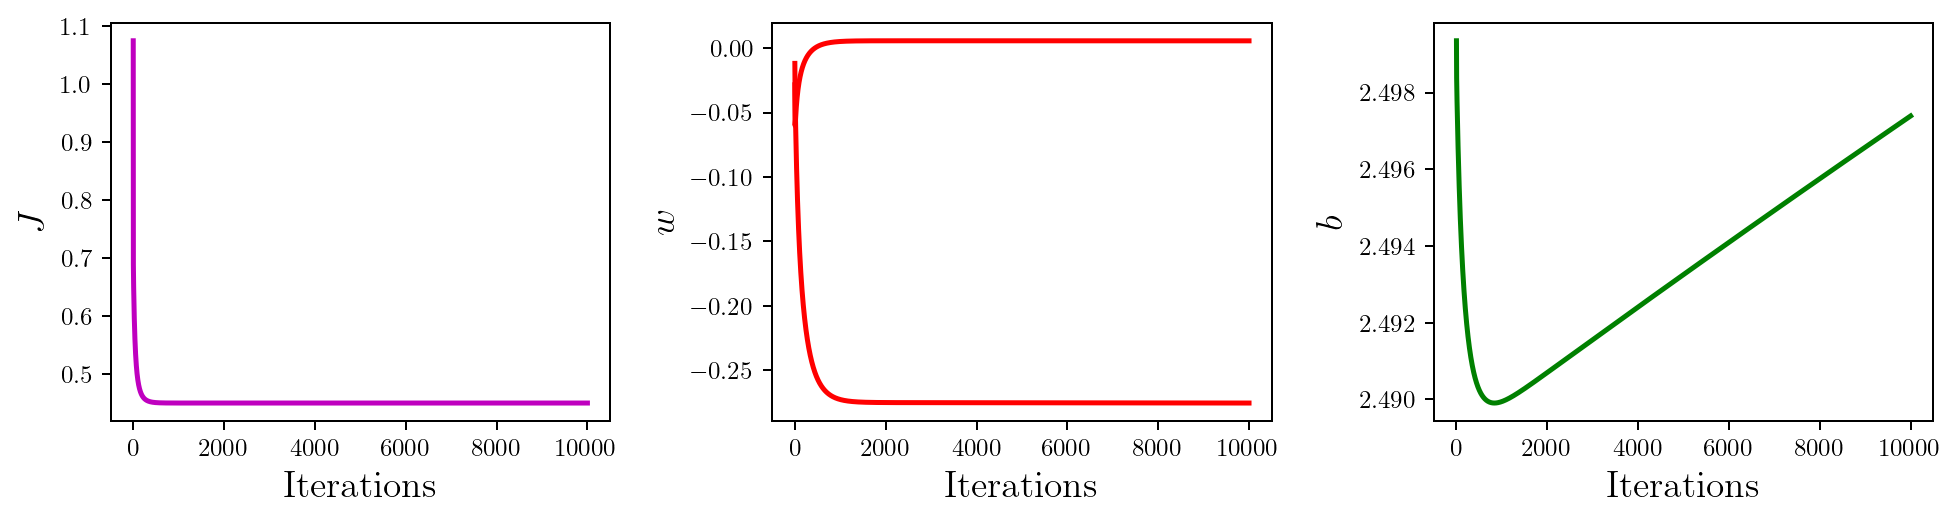

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(11,3), dpi=180)
ax1.plot(np.arange(len(J_hist)), J_hist, lw=2, c='m')
ax2.plot(np.arange(len(w_hist)), w_hist, lw=2, c='r')
ax3.plot(np.arange(len(b_hist)), b_hist, lw=2, c='g')
pt = 15

ax1.set_xlabel(r'Iterations',fontsize=pt)
ax2.set_xlabel(r'Iterations',fontsize=pt)
ax3.set_xlabel(r'Iterations',fontsize=pt)
ax1.set_ylabel(r'$J$',fontsize=pt)
ax2.set_ylabel(r'$w$',fontsize=pt)
ax3.set_ylabel(r'$b$',fontsize=pt)
plt.tight_layout()
plt.show()

To plot the decision boundary we should use the fact that for $g(z) \geq 0.5$ we have a class, otherwise we have another class. The same is valid for $z \geq 0$ and $z < 0$. $z = 0$ is a boundary of classes. $z = 0$ means $y = 0$, and also

$$w_1 x_1 + w_2 x_2 + b = 0$$
which means that the boundary is given by the linear equation

$$x_1 = - \frac{w_2}{w_1} x_2 - \frac{b}{w_1}$$

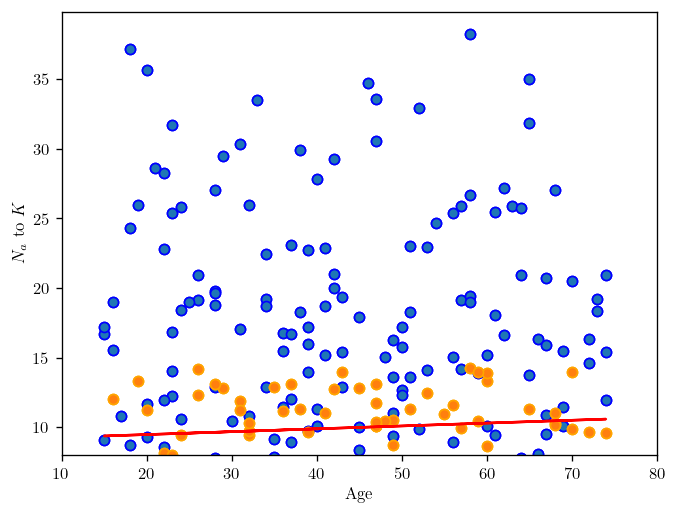

In [15]:
query1 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugX' or drug = 'DrugY'"
query2 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugA' or drug = 'drugB' or drug = 'drugC'"
d_xy = np.array(cursor.execute(query1).fetchall())
d_123 = np.array(cursor.execute(query2).fetchall())

age_xy = d_xy[:,0]
Na_xy = d_xy[:,1]
age_123 = d_123[:,0]
Na_123 = d_123[:,1]

# age_xy = scale_z_score(age_xy)
# Na_xy = scale_z_score(Na_xy)
# age_123 = scale_z_score(age_123)
# Na_123 = scale_z_score(Na_123)

plt.figure(dpi=120)
plt.scatter(age_xy, Na_xy, edgecolor='b')
plt.scatter(age_123, Na_123, edgecolor='orange')
plt.plot(X[:,0], -w[0]/w[1]*X[:,0] - b/w[1], 'r')
plt.xlim(10,80)
plt.ylim(8,)
plt.xlabel('Age')
plt.ylabel(r'$N_a$ to $K$')
plt.show()

For scaled features (and parameters):

In [16]:
m,n = Xs.shape
ws_init = np.zeros(n)
bs_init = 2.5
alpha = 1e-1
lambda_ = 0.5

ws, bs, J_hist, w_hist, b_hist = gradient_descent(Xs, y, ws_init, bs_init, alpha, lambda_, 10000)

Iteration    0: Cost 1.8456267826826254
Iteration 1000: Cost 0.45232772652069864
Iteration 2000: Cost 0.45223792867011636
Iteration 3000: Cost 0.45223752639447046
Iteration 4000: Cost 0.45223752446472715
Iteration 5000: Cost 0.45223752445542653
Iteration 6000: Cost 0.45223752445538296
Iteration 7000: Cost 0.4522375244553828
Iteration 8000: Cost 0.45223752445538196
Iteration 9000: Cost 0.4522375244553827


In [ ]:
cursor.execute("INSERT INTO results values (?,?,?,?,?)",('own','yes',ws[0],ws[1],bs))

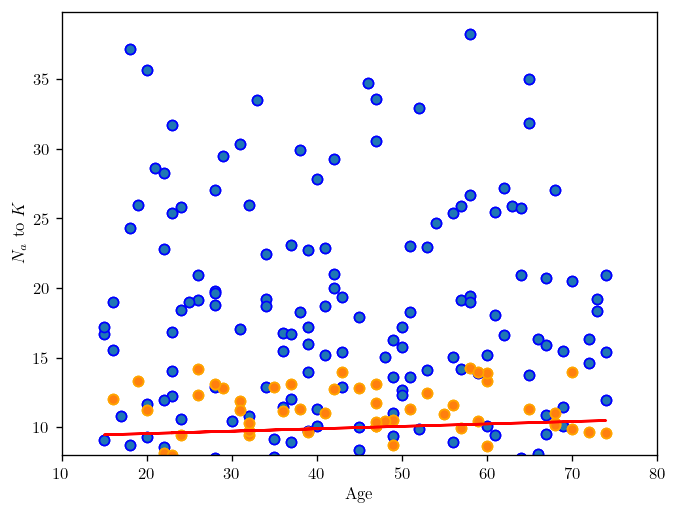

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

query1 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugX' or drug = 'DrugY'"
query2 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugA' or drug = 'drugB' or drug = 'drugC'"
d_xy = np.array(cursor.execute(query1).fetchall())
d_123 = np.array(cursor.execute(query2).fetchall())

age_xy = d_xy[:,0]
Na_xy = d_xy[:,1]
age_123 = d_123[:,0]
Na_123 = d_123[:,1]

b = bs - ws[0]/sigma[0]*mean[0] - ws[1]/sigma[1]*mean[1]
w = np.array([ws[0]/sigma[0], ws[1]/sigma[1]])

plt.figure(dpi=120)
plt.scatter(age_xy, Na_xy, edgecolor='b')
plt.scatter(age_123, Na_123, edgecolor='orange')
plt.plot(X[:,0], -w[0]/w[1]*X[:,0] - b/w[1], 'r')
plt.xlim(10,80)
plt.ylim(8,)
plt.xlabel('Age')
plt.ylabel(r'$N_a$ to $K$')
plt.show()

Using scikit-learn:

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [6]:
y_prediction = model.predict(X)

In [7]:
score = model.score(X, y)
print(f'The score of the model is {100*score}%.')

The score of the model is 69.5%.


In [15]:
w1,w2 = model.coef_[0]
b = model.intercept_[0]
print(w1,w2,b)

0.004788209658897593 -0.2805514800534202 2.6036701358692147


Show the prediction in practice (red cross predicts drugs $xy$ and green dots predicts drugs 123):

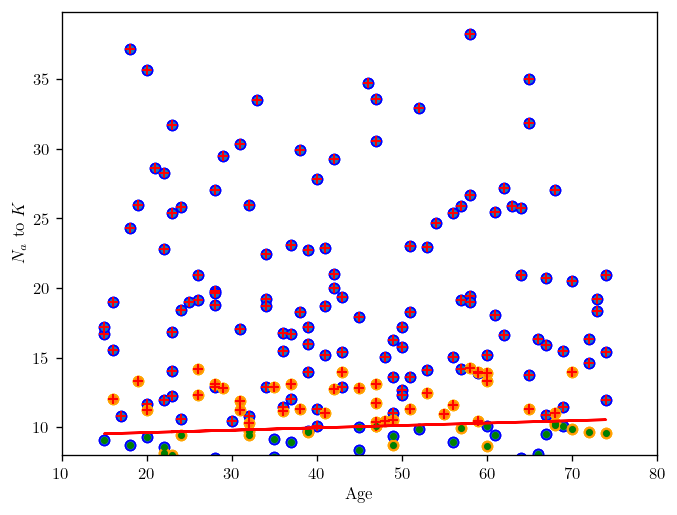

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

query1 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugX' or drug = 'DrugY'"
query2 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugA' or drug = 'drugB' or drug = 'drugC'"
d_xy = np.array(cursor.execute(query1).fetchall())
d_123 = np.array(cursor.execute(query2).fetchall())

plt.figure(dpi=120)

age_xy = d_xy[:,0]
Na_xy = d_xy[:,1]
age_123 = d_123[:,0]
Na_123 = d_123[:,1]

m,n = X.shape

for i in range(m):
    if y_prediction[i] == 0:
        mpred = '+'
        cpred = 'r'
    elif y_prediction[i] == 1:
        mpred = '.'
        cpred = 'g'
    plt.plot(X[i,0], X[i,1], marker=mpred, c=cpred)

plt.plot(X[:,0], -w1/w2*X[:,0] - b/w2, 'r')

plt.scatter(age_xy, Na_xy, edgecolor='b')
plt.scatter(age_123, Na_123, edgecolor='orange')
plt.xlim(10,80)
plt.ylim(8,)
plt.xlabel('Age')
plt.ylabel(r'$N_a$ to $K$')
plt.show()

The variables are ficticius and they are not much distinguishible, since there were no criteria to select features, then the results were not relevant, with no accuracy. Take this just as a learning example.